# Neural Correlates of Volitional Grasp Control

## Pre-processing

In [213]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import mne
import pyxdf


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from scipy.signal import find_peaks, spectrogram, filtfilt
from scipy.signal import butter, lfilter
from scipy.signal import welch

## Generate Spectopo Plots

In [ ]:
# Utility functions
def extract_mne_data_from_xdf(xdf_file):
    # Load the xdf file
    data, fileheader = pyxdf.load_xdf(xdf_file)
    montage = mne.channels.make_standard_montage("GSN-HydroCel-64_1.0")
    mne_info = mne.create_info(montage.ch_names, sfreq=sf, ch_types="eeg")
    raw_mne = mne.io.RawArray(data[0]["time_series"].T, mne_info, verbose=True)
    raw_mne.set_montage(montage)
    return raw_mne

def get_trial_dat(clean_data, Subject, Hand, handPos, Trial, Action):
    return {"eeg": clean_data[
        (clean_data["Subject"] == Subject) & 
        (clean_data["Hand"] == Hand) & 
        (clean_data["handPos"] == handPos) & 
        (clean_data["Trial"] == Trial) & 
        (clean_data["Action"] == Action)].to_numpy()[:, :-6].astype(np.float32), 
        "info": {"Subject": Subject, "Hand": Hand, "handPos": handPos, "Trial": Trial, "Action": Action},
        "timestamp": clean_data.columns[:-6]
        }



In [ ]:
data_path = r"E:\University\IIT Gandhinagar\EEG-Open-Close\EEG-based-BCI-for-grasp-prediction\Data\Raw Data"
clean_data_path = r"E:\University\IIT Gandhinagar\EEG-Open-Close\EEG-based-BCI-for-grasp-prediction\Data\Cleaned\Clean_Data.csv"
plots_path = r"E:\University\IIT Gandhinagar\EEG-Open-Close\EEG-based-BCI-for-grasp-prediction\Data\Plots\Spectopo Bandwise"
nChannels = 64
os.chdir(data_path)

clean_data = pd.read_csv(clean_data_path)

In [233]:
sf = 250
meta = clean_data.iloc[:, -6:]
clean_data.head()

,-100,-96,-92,-88,-84,-80,-76,-72,-68,-64,...,1984,1988,1992,1996,handPos,Hand,Action,Subject,Channel,Trial
0,0.992095,1.045134,0.821468,0.452555,0.167359,0.094921,0.189011,0.329643,0.452000,0.571202,...,0.901282,1.205751,1.477981,1.604695,palmDown,Right,Open,P01,E1,1
1,2.327051,1.829087,1.126410,0.539903,0.254767,0.220154,0.275524,0.326122,0.358070,0.339999,...,1.157870,1.758465,2.152331,2.008305,palmDown,Right,Open,P01,E2,1
2,1.469934,0.977102,0.371654,-0.247481,-0.769376,-1.051254,-0.927896,-0.341758,0.494546,1.133734,...,3.734554,2.259370,0.694383,-0.241412,palmDown,Right,Open,P01,E3,1
3,1.174265,0.275177,-0.301046,-0.423238,-0.229120,0.078764,0.419357,0.789833,1.066523,0.971994,...,7.144750,6.395225,5.569899,4.741736,palmDown,Right,Open,P01,E4,1
4,2.255072,1.371588,0.617765,0.299977,0.366954,0.458520,0.244992,-0.272633,-0.790045,-1.003268,...,-4.013077,-3.801898,-3.589362,-3.451835,palmDown,Right,Open,P01,E5,1


In [ ]:
def get_band_pass_eeg(eeg, sf, band):
    b, a = butter(4, [band[0] / (sf / 2), band[1] / (sf / 2)], btype='band')
    return filtfilt(b, a, eeg, axis=1)

def plot_spectopo_bandwise(eeg, eeg_plt_key, sf, bands=[(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta'), (30, 45, 'Gamma')], save=False):
    f, ax = plt.subplots(1, len(bands), figsize=(25, 5))
    
    for i, band in enumerate(bands):
        eeg["band_proc"] = get_band_pass_eeg(eeg[eeg_plt_key], sf, band)
        all_chan_spec = []
        for ch in range(eeg["band_proc"].shape[0]):
            f_s, t_s, Sxx = spectrogram(eeg["band_proc"][ch, :], fs=sf, nperseg=256, noverlap=250, window='hann')
            all_chan_spec.append(np.mean(Sxx[(f_s >= band[0]) & (f_s < band[1]), :], axis=0))
        all_chan_spec = np.array(all_chan_spec)
        
        im = ax[i].pcolormesh(t_s, np.arange(0, all_chan_spec.shape[0]), all_chan_spec, cmap='viridis')
        ax[i].set_title(band[2])
        ax[i].set_ylabel('Channel')
        ax[i].set_xlabel('Time [sec]')
        ax[i].axline((0.6, 0), (0.6, 1), color='red', ls="--", lw=1, label="Start")
        cbar = plt.colorbar(im, ax=ax[i])
        cbar.set_label("Power (dB)")
        ax[i].legend()
    # print("freqs: ", f.shape, " times: ", t_s.shape, " spectrogram: ", Sxx.shape, " spectopo: ", all_chan_spec.shape)
    plt.tight_layout()
    plt.show()
    if save:
        os.makedirs(plots_path, exist_ok=True)
        img_name = "__".join([str(x) + "_" + str(y) for x, y in zip(trial_data["info"].keys(), trial_data["info"].values())])
        save_path = os.path.join(plots_path, f'Spectopo__{img_name}.png')
        
        f.savefig(save_path, dpi=300)

Subjs, Hands, handPoses, Trials, Actions = np.unique(meta["Subject"]), np.unique(meta["Hand"]), np.unique(meta["handPos"]), np.unique(meta["Trial"]), np.unique(meta["Action"])
for sub in Subjs:
    for hand in Hands:
        for handPos in handPoses:
            for trial in Trials:
                for action in Actions:
                    trial_data = get_trial_dat(clean_data, sub, hand, handPos, trial, action)
                    print("#####", trial_data["info"], "#####")
                    # print(trial_data, trial_data["eeg"].shape, trial_data["info"], trial_data["timestamp"])
                    # plot_spectopo_bandwise(trial_data, "eeg", sf, save=True)



In [262]:
# trial_data["info"].keys(), trial_data["info"].values()
"__".join([str(x) + "_" + str(y) for x, y in zip(trial_data["info"].keys(), trial_data["info"].values())])

'Subject_FP01__Hand_Left__handPos_palmDown__Trial_1__Action_Close'

In [ ]:
meta

### Preprocessing (Redundant, clean available below)

In [ ]:
os.getcwd()
data_path = r"E:\University\IIT Gandhinagar\EEG-Open-Close\EEG-based-BCI-for-grasp-prediction\Data\Raw Data"
os.chdir(data_path)
os.getcwd()

'E:\\University\\IIT Gandhinagar\\EEG-Open-Close\\EEG-based-BCI-for-grasp-prediction\\Data\\Raw Data'

In [93]:
nChannels = 64
sf = 1000

In [8]:
eeg_files = glob.glob("*.xdf")
print(eeg_files)

['FP01.xdf', 'FP02.xdf', 'FP03.xdf', 'FP05.xdf', 'FP06.xdf', 'FP07.xdf', 'FP08.xdf', 'FP09.xdf', 'FP10.xdf', 'FP11.xdf', 'FP12.xdf', 'FP13.xdf', 'P01.xdf', 'P02.xdf', 'P03.xdf']


In [ ]:

file_path = os.path.join(data_path, eeg_files[0])
data, header = pyxdf.load_xdf(file_path)

data[0]["time_series"].shape

(1906624, 64)

In [57]:
montage = mne.channels.make_standard_montage("GSN-HydroCel-64_1.0")
mne_info = mne.create_info(montage.ch_names, sfreq=sf, ch_types="eeg")
raw_mne = mne.io.RawArray(data[0]["time_series"].T, mne_info, verbose=True)
raw_mne.set_montage(montage)
raw_mne

Creating RawArray with float64 data, n_channels=64, n_times=1906624
    Range : 0 ... 1906623 =      0.000 ...  1906.623 secs
Ready.


<RawArray | 64 x 1906624 (1906.6 s), ~931.0 MiB, data loaded>

(64, 1906624)


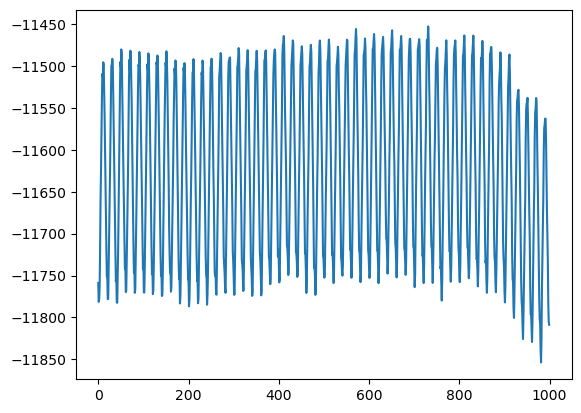

In [67]:
raw_np = raw_mne.get_data()
print(raw_np.shape)
plt.plot(raw_np[0, :1000])
plt.show()

In [ ]:
raw_mne.filter(l_freq=0.1, h_freq=45.0)
raw_mne.plot_psd(fmin=0, fmax=50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


<RawArray | 64 x 1906624 (1906.6 s), ~931.0 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\shiva\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


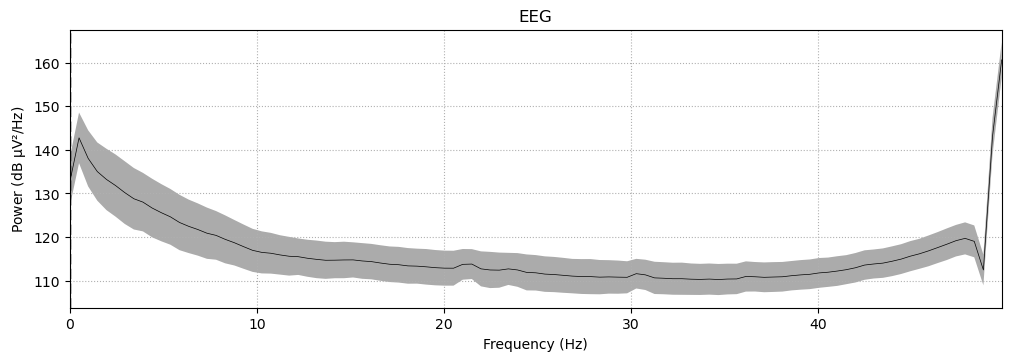

In [49]:
raw_mne.plot_psd(fmin=0, fmax=50, average=True)
plt.show()

Filtering raw data in 1 contiguous segment


Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s



Power Spectral Density (PSD) after filtering:
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\shiva\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


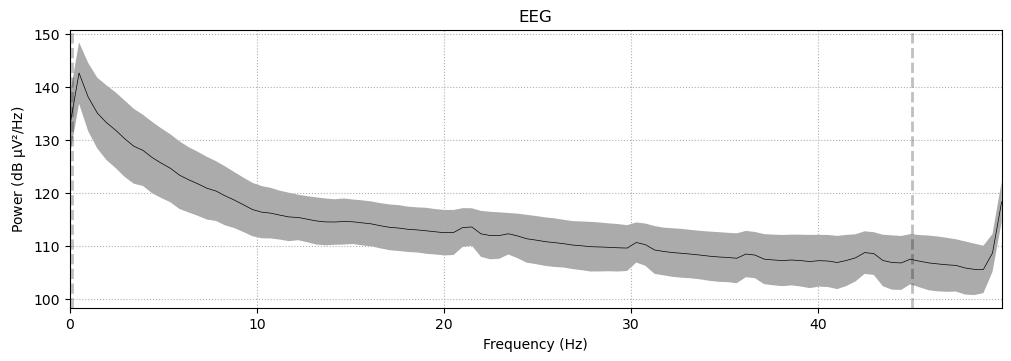

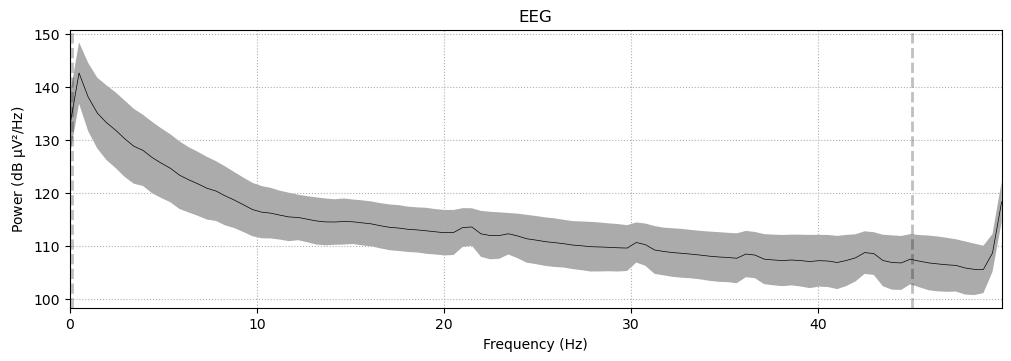

In [ ]:
# a) Bandpass filter (remove slow drifts and high freq noise)
raw_mne.filter(l_freq=0.1, h_freq=45.0)

# b) Notch filter for powerline noise (Choose 50 or 60 Hz depending on country)
# Example for 50 Hz (India/Europe), or switch to 60 for USA
raw_mne.notch_filter(freqs=[50, 100], picks='eeg')  # Also removing 1st harmonic

# -----------------------------------
# 5. Plot PSD after filtering
# -----------------------------------
print("\nPower Spectral Density (PSD) after filtering:")
raw_mne.plot_psd(fmin=0, fmax=50, average=True)
plt.show()


In [53]:
raw_data_numpy = raw_mne.get_data()
raw_data_numpy.shape

(64, 1906624)

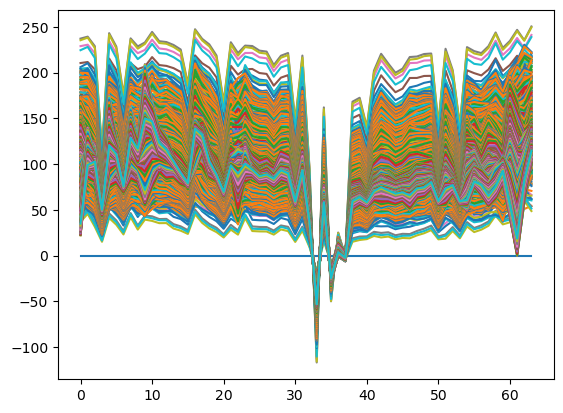

In [ ]:
plt.plot(raw_data_numpy[:, :1000])
plt.show()

### Using cleaned data

In [68]:
clean_data_path = r"E:\University\IIT Gandhinagar\EEG-Open-Close\EEG-based-BCI-for-grasp-prediction\Data\Cleaned\Clean_Data.csv"
clean_data = pd.read_csv(clean_data_path)
clean_data.head()

,-100,-96,-92,-88,-84,-80,-76,-72,-68,-64,...,1984,1988,1992,1996,handPos,Hand,Action,Subject,Channel,Trial
0,0.992095,1.045134,0.821468,0.452555,0.167359,0.094921,0.189011,0.329643,0.452000,0.571202,...,0.901282,1.205751,1.477981,1.604695,palmDown,Right,Open,P01,E1,1
1,2.327051,1.829087,1.126410,0.539903,0.254767,0.220154,0.275524,0.326122,0.358070,0.339999,...,1.157870,1.758465,2.152331,2.008305,palmDown,Right,Open,P01,E2,1
2,1.469934,0.977102,0.371654,-0.247481,-0.769376,-1.051254,-0.927896,-0.341758,0.494546,1.133734,...,3.734554,2.259370,0.694383,-0.241412,palmDown,Right,Open,P01,E3,1
3,1.174265,0.275177,-0.301046,-0.423238,-0.229120,0.078764,0.419357,0.789833,1.066523,0.971994,...,7.144750,6.395225,5.569899,4.741736,palmDown,Right,Open,P01,E4,1
4,2.255072,1.371588,0.617765,0.299977,0.366954,0.458520,0.244992,-0.272633,-0.790045,-1.003268,...,-4.013077,-3.801898,-3.589362,-3.451835,palmDown,Right,Open,P01,E5,1


In [124]:
def get_trial_dat(Subject, Hand, handPos, Trial, Action):
    return {"eeg": clean_data[
        (clean_data["Subject"] == Subject) & 
        (clean_data["Hand"] == Hand) & 
        (clean_data["handPos"] == handPos) & 
        (clean_data["Trial"] == Trial) & 
        (clean_data["Action"] == Action)].to_numpy()[:, :-6].astype(np.float32), 
        "info": {"Subject": Subject, "Hand": Hand, "handPos": handPos, "Trial": Trial, "Action": Action},
        "timestamp": clean_data.columns[:-6]
        }
trial_data = get_trial_dat("P01", "Right", "palmDown", 1, "Open")
trial_data, trial_data["eeg"].shape, trial_data["info"], trial_data["timestamp"]


({'eeg': array([[ 0.9920945 ,  1.0451344 ,  0.82146776, ...,  1.2057506 ,
           1.4779809 ,  1.6046951 ],
         [ 2.327051  ,  1.8290869 ,  1.1264099 , ...,  1.7584649 ,
           2.1523309 ,  2.0083046 ],
         [ 1.469934  ,  0.97710204,  0.37165418, ...,  2.2593696 ,
           0.694383  , -0.2414115 ],
         ...,
         [ 0.5101147 ,  1.445716  ,  1.096902  , ...,  3.5594978 ,
           3.8881555 ,  3.077469  ],
         [-1.3104581 , -0.36775282,  0.11390963, ..., -2.152929  ,
          -0.8266372 , -0.42903882],
         [-0.92898   , -0.49208367, -0.5140365 , ..., -2.8393953 ,
          -1.4924632 , -0.7062581 ]], dtype=float32),
  'info': {'Subject': 'P01',
   'Hand': 'Right',
   'handPos': 'palmDown',
   'Trial': 1,
   'Action': 'Open'},
  'timestamp': Index(['-100', '-96', '-92', '-88', '-84', '-80', '-76', '-72', '-68', '-64',
         ...
         '1960', '1964', '1968', '1972', '1976', '1980', '1984', '1988', '1992',
         '1996'],
        dtype='object

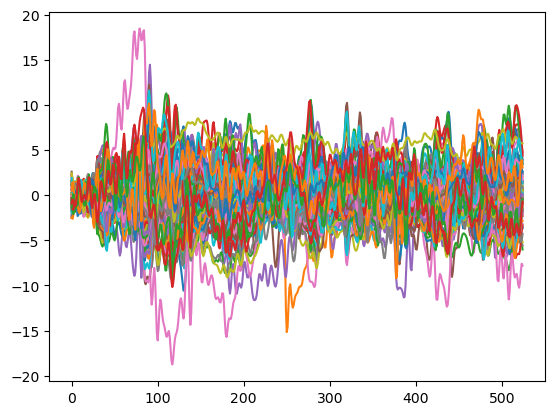

In [113]:
for ch in range(nChannels):
    plt.plot(trial_data["eeg"][ch, :])
plt.show()

In [117]:
np.std(trial_data["eeg"], axis=1)

array([1.8221841, 3.8491864, 2.4785604, 2.7768853, 3.9151378, 4.0859284,
       2.5466971, 2.0062637, 1.6234312, 2.245793 , 2.0253794, 1.5840092,
       2.1796882, 1.7385457, 1.5342175, 1.7552412, 7.317695 , 3.139946 ,
       2.300556 , 1.6186395, 1.4640955, 2.061791 , 2.8310578, 2.2091868,
       2.0642078, 2.0581448, 1.8511226, 1.7328484, 1.3096993, 1.8405676,
       1.6690534, 1.8905613, 1.7661321, 1.6918947, 1.5936465, 1.4676019,
       1.598332 , 1.8731103, 1.7961395, 1.5288854, 2.8018832, 1.9312196,
       2.2091794, 2.3392603, 2.8317535, 2.0466952, 1.6803559, 2.5898979,
       1.5417337, 1.8630221, 1.5901865, 1.4526528, 3.1129434, 2.9295955,
       2.170176 , 1.150842 , 1.7507147, 1.1148525, 2.1988986, 2.5918741,
       2.2575822, 2.6361477, 2.58288  , 3.5058024], dtype=float32)

Bad channels: [16]


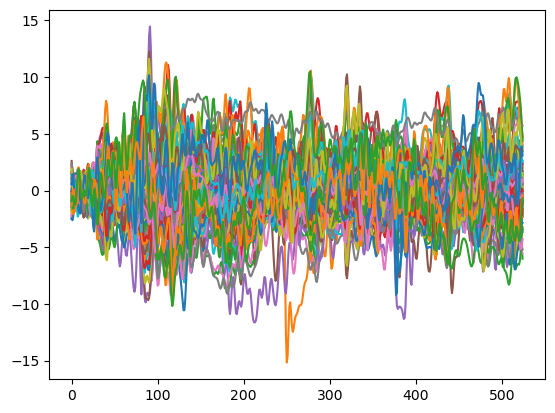

In [125]:
def remove_bad_channels(data, threshold=2):
    std = np.std(data["eeg"], axis=1)
    bad_channels = np.where(std > threshold * np.mean(std))[0]
    print(f'Bad channels: {bad_channels}')
    data["eeg_bad_chan"] = np.delete(data["eeg"], bad_channels, axis=0)
    return data

trial_data = get_trial_dat("P01", "Right", "palmDown", 1, "Open")
trial_data = remove_bad_channels(trial_data)

for ch in range(trial_data["eeg_bad_chan"].shape[0]):
    plt.plot(trial_data["eeg_bad_chan"][ch, :])
plt.show()

freqs:  (129,)  times:  Index(['-100', '-96', '-92', '-88', '-84', '-80', '-76', '-72', '-68', '-64',
       ...
       '1960', '1964', '1968', '1972', '1976', '1980', '1984', '1988', '1992',
       '1996'],
      dtype='object', length=525)  spectrogram:  (129, 45)  spectopo:  (63, 45)


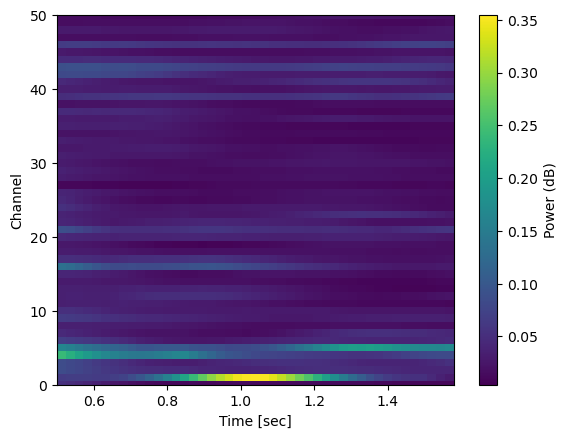

In [178]:
def plot_spectopo(eeg, sf, eeg_plt_key):
    spectopo = []
    for ch in range(eeg[eeg_plt_key].shape[0]):
        f, t, Sxx = spectrogram(eeg[eeg_plt_key][ch, :], fs=250, nperseg=256, noverlap=250, window='hann')
        spectopo.append(np.mean(Sxx, axis=0))

    spectopo = np.array(spectopo)
    print("freqs: ", f.shape, " times: ", eeg["timestamp"], " spectrogram: ", Sxx.shape, " spectopo: ", spectopo.shape)
    plt.pcolormesh(t, np.arange(0, eeg[eeg_plt_key].shape[0]), spectopo[:, :], cmap='viridis')
    plt.ylim(0, 50)
    plt.colorbar(label='Power (dB)')
    plt.ylabel('Channel')
    plt.xlabel('Time [sec]')
    plt.show()

plot_spectopo(trial_data, 250, "eeg_bad_chan")

freqs:  (129,)  times:  (45,)  spectrogram:  (129, 45)  spectopo:  (63, 45)


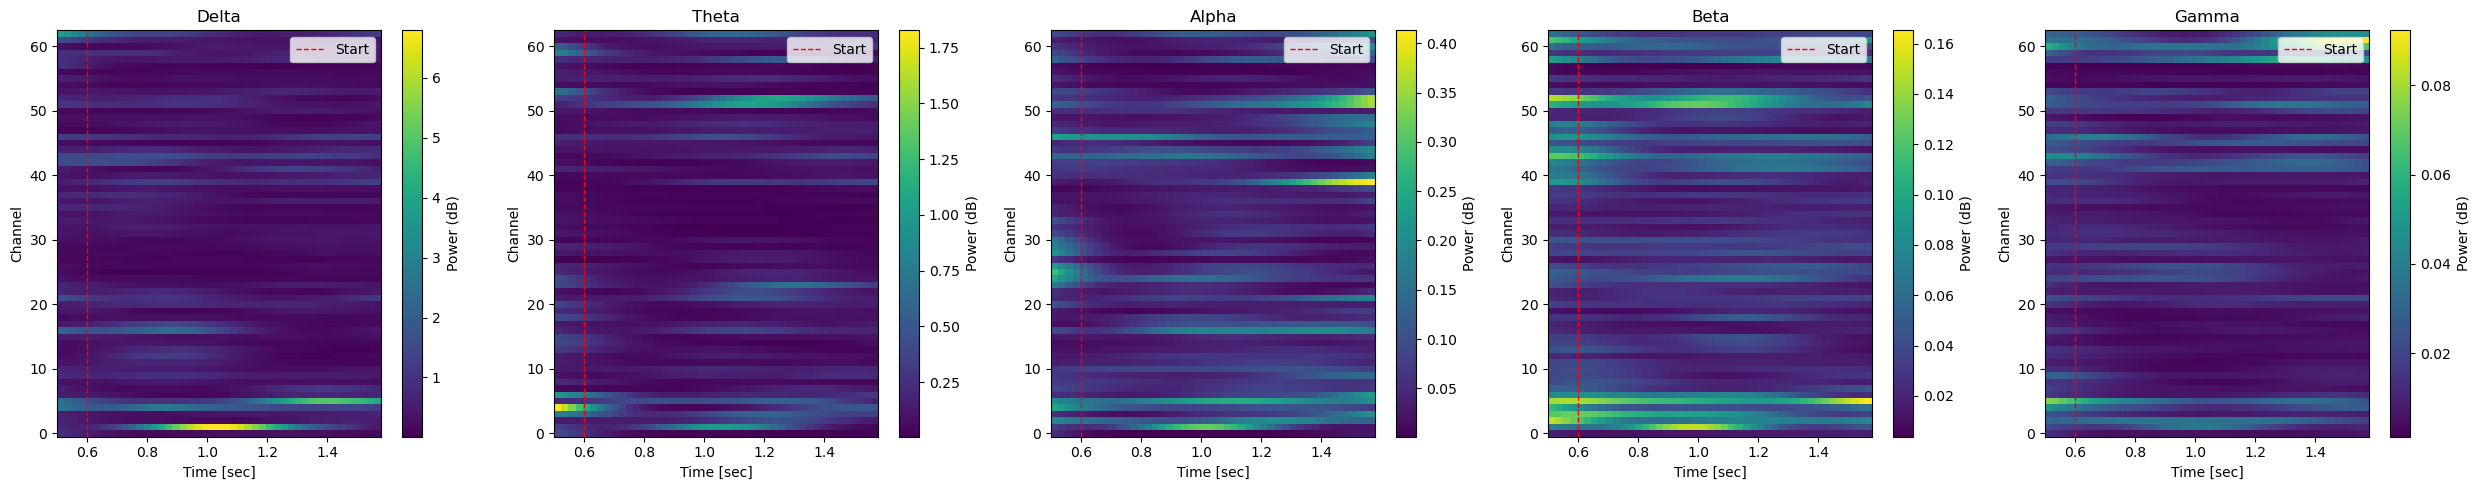

In [209]:
def get_band_pass_eeg(eeg, sf, band):
    b, a = butter(4, [band[0] / (sf / 2), band[1] / (sf / 2)], btype='band')
    return filtfilt(b, a, eeg, axis=1)

def plot_spectopo_bandwise(eeg, eeg_plt_key, sf, bands=[(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta'), (30, 45, 'Gamma')]):
    f, ax = plt.subplots(1, len(bands), figsize=(25, 5))
    
    for i, band in enumerate(bands):
        eeg["band_proc"] = get_band_pass_eeg(eeg[eeg_plt_key], sf, band)
        all_chan_spec = []
        for ch in range(eeg["band_proc"].shape[0]):
            f, t, Sxx = spectrogram(eeg["band_proc"][ch, :], fs=sf, nperseg=256, noverlap=250, window='hann')
            all_chan_spec.append(np.mean(Sxx[(f >= band[0]) & (f < band[1]), :], axis=0))
        all_chan_spec = np.array(all_chan_spec)
        
        im = ax[i].pcolormesh(t, np.arange(0, all_chan_spec.shape[0]), all_chan_spec, cmap='viridis')
        ax[i].set_title(band[2])
        ax[i].set_ylabel('Channel')
        ax[i].set_xlabel('Time [sec]')
        ax[i].axline((0.6, 0), (0.6, 1), color='red', ls="--", lw=1, label="Start")
        # ax[i].axline((0.6, 0), (1), color='black', ls="-", lw=1)
        cbar = plt.colorbar(im, ax=ax[i])
        cbar.set_label("Power (dB)")
        ax[i].legend()
    print("freqs: ", f.shape, " times: ", t.shape, " spectrogram: ", Sxx.shape, " spectopo: ", all_chan_spec.shape)
    plt.tight_layout()
    plt.show()

plot_spectopo_bandwise(trial_data, "eeg_bad_chan", 250)

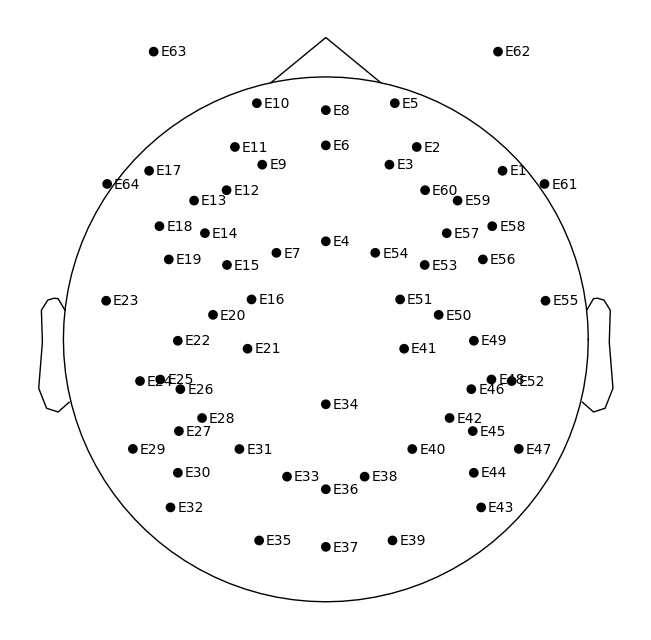

In [212]:
montage.plot(kind='topomap', show_names=True)
plt.show()